In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matrixprofile import *
import seaborn as sns
import stumpy
from matrixprofile.discords import discords
import ast  # For parsing strings back to lists

In [3]:
def load_npy(filename):
    return np.load(filename)


dir_path = 'cleaned_time_series/'
len_threshold = 1280
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0])  # track_id
    y.append(split[1][:-4])  # genre
    ts = load_npy(dir_path + file)

    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
        ts = np.append(ts, pad)

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)
print(len(X))

10000


**Analysis of the dataset to find motifs and/or anomalies**

# Matrix Profile (Overview)
• The Matrix Profile (MP) is a data structure that annotates a TS and
can be exploited for many purposed: e.g. efficient Motif Discovery.

## Here using matrixprofile library (the one given by the professor)

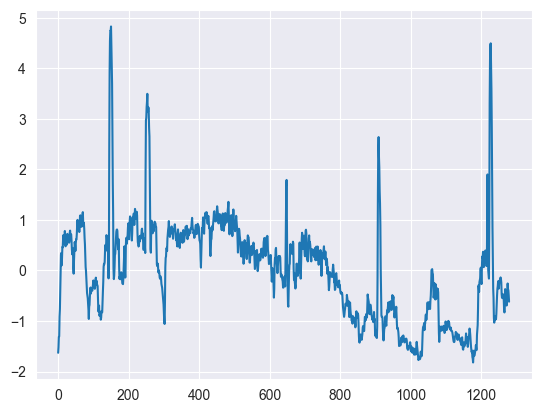

In [178]:
plt.plot(X[0,-1].T)
plt.show()

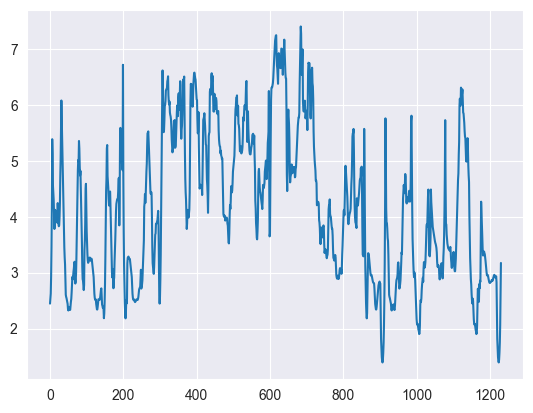

In [177]:
w = 50
ts = pd.Series(X[0,-1].T)
mp, mpi = matrixProfile.stomp(ts.values, w)
'''
The function *stomp* returns two arrays:
mp (Matrix Profile): An array where each element represents the smallest distance between a subsequence in the time series and its nearest, non-trivial matching subsequence.
mpi (Matrix Profile Index): An array of the indices where these minimum distances occur.
'''
plt.plot(mp)
plt.show()

## Here using stumpy library

In [ ]:
X[0,-1].T

In [8]:
m = 50
y = X[0,-1].T
x = range(0,1280)
matrix_profile = stumpy.stump(y, m)

In [9]:
matrix_profile

array([[2.4463225322360587, 299, -1, 299],
       [2.5459000660221998, 299, -1, 299],
       [2.625772319111305, 300, -1, 300],
       ...,
       [2.0616009407164317, 911, 911, -1],
       [2.545789678780108, 912, 912, -1],
       [3.17308952017819, 913, 913, -1]], dtype=object)

In [10]:
matrix_profile_df = pd.DataFrame(matrix_profile, columns=['profile', 'profile index', 'left profile index', 'right profile index'])

In [11]:
matrix_profile_df

,profile,profile index,left profile index,right profile index
0,2.446323,299,-1,299
1,2.5459,299,-1,299
2,2.625772,300,-1,300
3,2.933148,301,-1,301
4,3.458027,301,-1,301
...,...,...,...,...
1226,1.56604,909,909,-1
1227,1.751605,910,910,-1
1228,2.061601,911,911,-1
1229,2.54579,912,912,-1


# Motif discovery (Overview)

## Using the matrix profile calculated by stumpy

The best motif is the one where the profile is the smallest (since the profile is the distance value)

Checking for the minimum will give us two matches, each of these should refer to each other which can be see by looking at the profile index:

In [12]:
best_motif = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].min()]
best_motif

,profile,profile index,left profile index,right profile index
907,1.393428,1224,147,1224
1224,1.393428,907,907,-1


We can plot this motif:

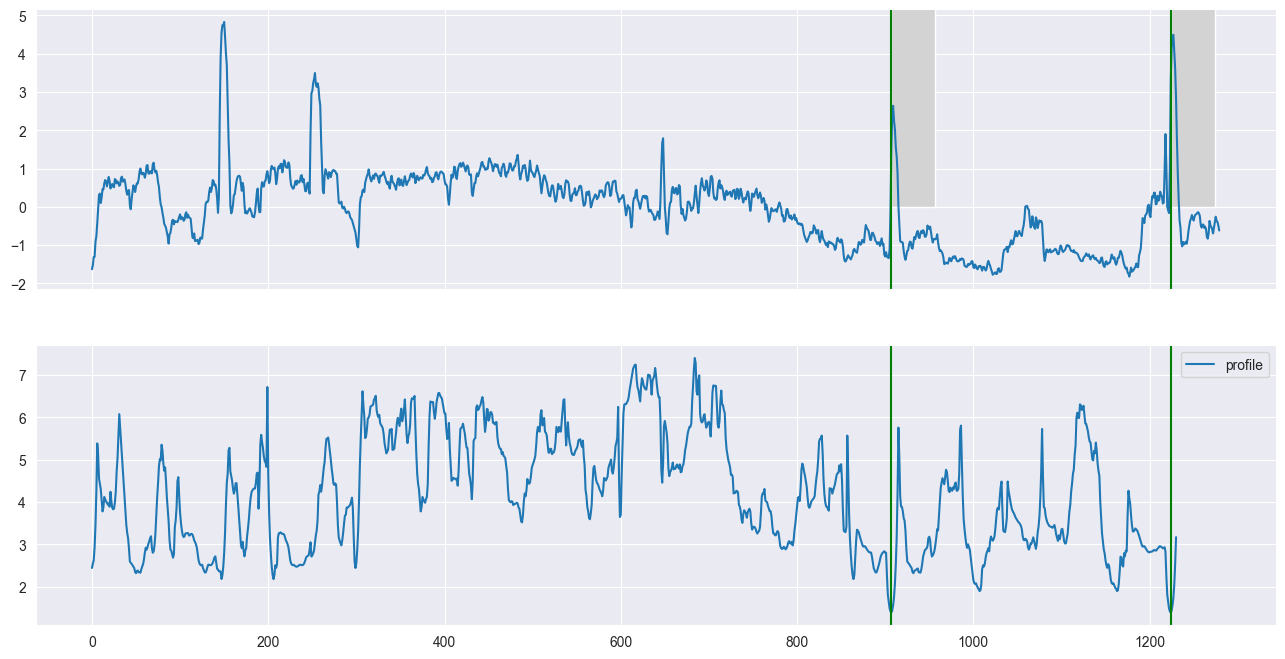

In [13]:
from matplotlib.patches import Rectangle

profile_df = matrix_profile_df[['profile']]

fig, ax = plt.subplots(2, figsize=(16,8), sharex=True)
g1 = sns.lineplot(y=y, x=x, ax=ax[0])
g2 = sns.lineplot(data=profile_df, ax=ax[1])

for idx in best_motif.index.to_list():
    g1.axvline(x=idx, color="green")
    g2.axvline(x=idx, color="green")
    rect = Rectangle((idx, 0), m, 40, facecolor="lightgrey")
    g1.add_patch(rect)

We can also see the above zoomed in:

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))

for idx in best_motif.index.to_list():
    plot_y = y.iloc[idx:(idx+m)].to_list()
    sns.lineplot(data=plot_y, ax=ax)

Comparatively, we can compare two random subsequences which don't have any specific relation



In [ ]:
fig, ax = plt.subplots(figsize=(16,4))

for idx in [0, 1000]:
    plot_y = y.iloc[idx:(idx+m)].to_list()
    sns.lineplot(data=plot_y, ax=ax)

## Find a discord/anomaly

Potential **discords/anomalies** can be located as data that's most different to any existing datapoints, this can be found by finding the max profile distance. We can find the anomaly segment by getting this value and plotting it below:

In [ ]:
discord = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].max()]
discord

In [ ]:
fig, ax = plt.subplots(2, figsize=(16,8), sharex=True)
g1 = sns.lineplot(y=y, x=x, ax=ax[0])
g2 = sns.lineplot(data=profile_df, ax=ax[1])


rect = Rectangle((discord.index[0], 0), m, 40, facecolor="lightgrey")
g1.add_patch(rect)
g2.axvline(x=[discord.index[0]], color='C1')

## Using the matrix profile calculated by matrixprofile library (the one given by the professor)

In [ ]:
mo, mod  = motifs.motifs(ts.values, (mp, mpi), max_motifs=1)

Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.

Returns
The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.


In [26]:
mo

[[147, 907, 1224], [280, 1007, 1163], [103, 206, 864]]

In [27]:
mod

[1.3934280967837902, 1.9015054711640265, 2.1829225492506477]

In [ ]:
plt.plot(ts.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

In [ ]:
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

## find a discord/anomaly (using matrixprofile library) (the one given by the professor)

Parameters  
- mp: matrix profile numpy array
- k: the number of discords to discover
- ex_zone: the number of samples to exclude and set to Inf on either side of a found discord    

Returns 
 - a list of indexes represent the discord starting locations. MaxInt indicates there were no more discords that could be found due to too many exclusions or profile being too small. Discord start indices are sorted by highest matrix profile value.

In [ ]:
anoms = discords(mp, ex_zone=3, k=1)

In [ ]:
anoms

In [ ]:
plt.plot(ts.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = ts.values[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
x = ts.values
plt.plot(range(len(x)), x, marker='o', color='r')
plt.xticks(range(len(x)))
plt.grid()
plt.show()

In [ ]:
w = 3
mp = np.array([np.inf] * (len(x) - w + 1))
for i in range(len(x) - w + 1):
    #print('a', x[i:i+w])
    for j in range(len(x) - w + 1):
        if i == j:
            continue
        #print('b', x[j:j+w])
        val = 0
        for k in range(w):
            val += np.abs(x[i + k] - x[j + k])
        #print(val)
        mp[i] = min(mp[i], val)
    #print('')
        

In [ ]:
mp

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(mp, marker='o', color='b')
plt.xticks(range(len(mp)))
plt.grid()
plt.show()

In [ ]:
mp, mpi = matrixProfile.naiveMP(ts.values, m=12)

# Matrix Profile in entire dataset

## Using stumpy library

## Using matrixprofile library (the one given by the professor)

In [40]:
ts = pd.Series(X[0,-1].T)
mp, mpi = matrixProfile.stomp(ts.values, w)
mo, mod  = motifs.motifs(ts.values, (mp, mpi), max_motifs=3)
anoms = discords(mp, ex_zone=3, k=3)



In [44]:
anoms

array([684, 617, 639])

In [65]:
# Initialize the directory paths
best_motif_dir = 'best_motifs'
best_discord_dir = 'best_discord'

# Create directories if they don't exist
os.makedirs(best_motif_dir, exist_ok=True)
os.makedirs(best_discord_dir, exist_ok=True)

w = 40 # window size

for i in range(3):
    ts = pd.Series(X[i,-1].T)
    mp, mpi = matrixProfile.stomp(ts.values, w)
    mo, mod  = motifs.motifs(ts.values, (mp, mpi), max_motifs=3)
    anoms = discords(mp, ex_zone=3, k=3)


    motif_df = pd.DataFrame({'Motifs': [str(m) for m in mo]})
    motif_df.to_csv(os.path.join(best_motif_dir, f'best_motif_series_{i}.csv'), index=False)

    print(f"Best motif for {i}: {mo}")
    print(f"Discord for {i}: {anoms}")

    #best_motif.to_csv(f'best_motifs/best_motif_series_{i}.csv', index=False)
    discord_df = pd.DataFrame({'Discords': anoms})
    discord_df.to_csv(os.path.join(best_discord_dir, f'discord_series_{i}.csv'), index=False)

Best motif for 0: [[147, 907, 1224], [251, 955], [176, 289, 1018, 1174]]
Discord for 0: [683 723 621]
Best motif for 1: [[552, 595, 638, 724, 767], [294, 466, 897, 940, 983, 1069, 1112, 1155], [207, 250, 379]]
Discord for 1: [4 0 7]
Best motif for 2: [[960, 1014, 1046, 1100, 1132, 1185], [17, 100, 142, 514, 776], [708, 1206]]
Discord for 2: [876 607 883]


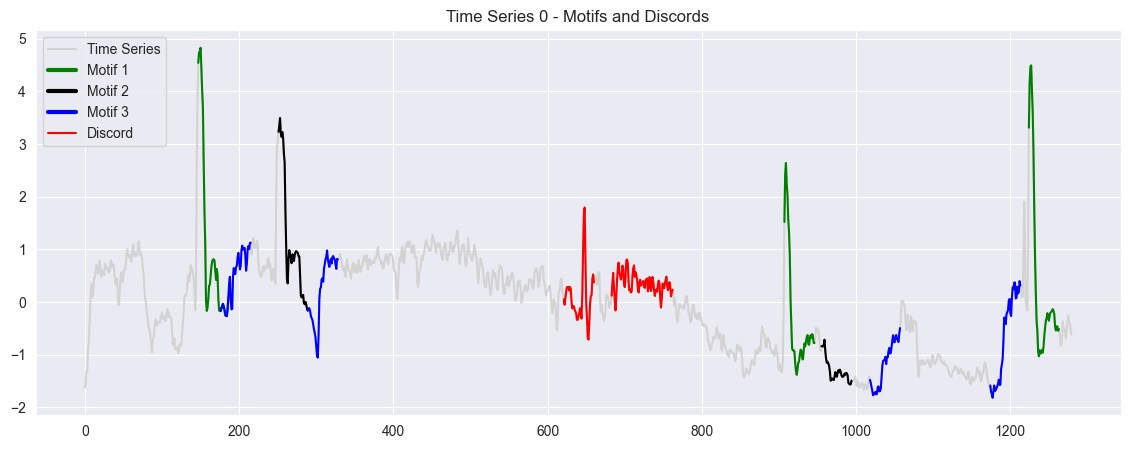

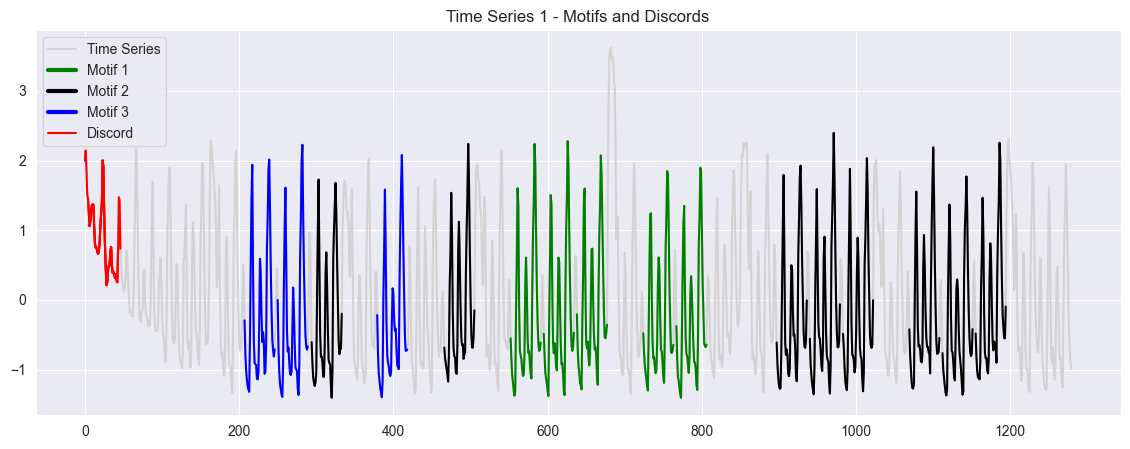

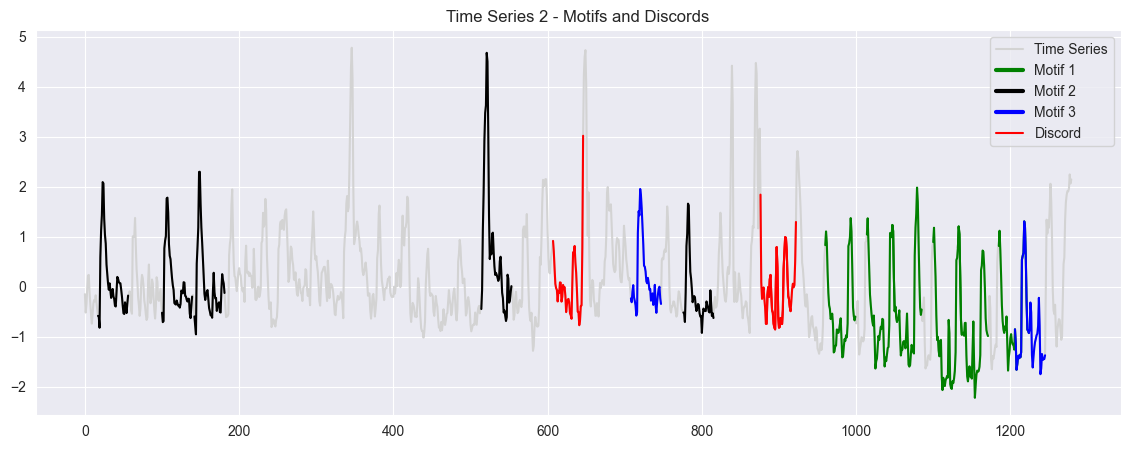

In [67]:
# Number of time series
num_series = 3

colors = ['g', 'k', 'b', 'y']
# Plotting each series' motifs and discords
for i in range(num_series):
    # Load motifs and discords from CSV
    best_motif = pd.read_csv(f'best_motifs/best_motif_series_{i}.csv')
    discord = pd.read_csv(f'best_discord/discord_series_{i}.csv')

    # Assuming you have the original time series data in 'X'
    y = X[i, -1].T

    # Create a plot for the time series and its motifs/discords
    plt.figure(figsize=(14, 5))
    plt.title(f"Time Series {i} - Motifs and Discords")
    plt.plot(y, label='Time Series', color='lightgray')

    # Highlight motifs and discords
    color_index = 0
    for index, motif in enumerate(best_motif['Motifs']):
        motif_indices = ast.literal_eval(motif)  # Convert string back to list
        color = colors[color_index % len(colors)]  # Cycle through colors if there are more motifs than colors
        for start_index in motif_indices:
            plt.plot(range(start_index, start_index + w), y[start_index:start_index + w], label=f'Motif {index + 1}', color=color)
        plt.plot([], [], color=color, label=f'Motif {index + 1}', linewidth=3)  # Add legend entry
        color_index += 1


# Highlight discords
    for discord_index in discord['Discords']:
        start_index = int(discord_index)
        plt.plot(range(start_index, start_index + w), y[start_index:start_index + w], label='Discord', color='red')


    # Ensure legends are not repeatedly added
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()
